In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import cv2
from matplotlib import pyplot as plt
import time
import os, re, os.path
from ipywidgets import interact, widgets
from IPython.display import clear_output
import numpy as np
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models

## Data collection

### Which chord will you train at this time?

In [2]:
# Display input controls 
print("Which chord will you capture data for?")
chord_option = widgets.Dropdown(
 options=["C","D", "E","F","G","A","B", "_BG"],
 value = "A",
 description="Chord"
 )

clean_current_chord_data = widgets.Checkbox(
    value=False,
    description="Clean existing training data? ",
    disabled=False,
    indent=False
)

display(chord_option)
display(clean_current_chord_data)

Which chord will you capture data for?


Dropdown(description='Chord', index=5, options=('C', 'D', 'E', 'F', 'G', 'A', 'B', '_BG'), value='A')

Checkbox(value=False, description='Clean existing training data? ', indent=False)

In [3]:
print("You will capture data for the " + chord_option.value + " chord.")
print("Clean up existing training data: " + str(clean_current_chord_data.value))

You will capture data for the A chord.
Clean up existing training data: False


In [4]:
chord = chord_option.value
cleanup = clean_current_chord_data.value
output_path = "output/" + chord + "/"

# this saves the index of the next image in the directory. If I'm not cleaning 
# up the directory, it needs to start with the next image file name number
i = 0 

# define a video capture object
vid = cv2.VideoCapture(1)

# Create the needed folders or delete files if needed
if not os.path.exists(output_path):
    # if the folder doesn't exist, create it
    os.makedirs(output_path)
elif cleanup:
    #if it does, clean it up if desired
    for f in os.listdir(output_path):
        os.remove(os.path.join(output_path, f))
else: 
    i = len(os.listdir(output_path))

chord_legend = cv2.imread("chords/%s.jpg" % chord, cv2.IMREAD_COLOR)

camera_widget = widgets.Image(
    format='jpg',
    width=300,
    height=400,
)

# The little square showing the current chord will be 80 x 80
legend_size = 80
W = 640
center_column = W // 2 - legend_size // 2

# Proof of concept: 
# - Showing live video with a legend of the current chord
# - Saving the frame to disc

# SET THIS TO TRUE ONLY WHEN YOU WANT TO RUN THIS AGAIN
run_data_capture = False 

# How many frames per chord do I want to capture in one routine?
photo_count = 250
if run_data_capture: 
    for image in range(photo_count):
        clear_output(wait=True)
        i += 1
        file_name = output_path + "{:03d}.jpg".format(i)

        # Capture the video frame by frame
        ret, frame = vid.read()

        # I can show the chord in a small square in the top/center of the frame    
        H,W,C = frame.shape

        #Save to disc before I add the legend 
        cv2.imwrite(file_name, frame)

        # Show the chord in the center of the top row
        frame[0:legend_size, W - legend_size - center_column:W - legend_size - center_column + legend_size] = chord_legend

        # Display the resulting framefrom IPython.display import clear_output
        plt.title('Camera feed')
        plt.imshow(frame)
        plt.show()

        #How many frames do I want to capture per second? 
        time.sleep(0.12)

        #print("Hi there")

        # the 'q' button is set as the
        # quitting button you may use any
        # desired button of your choice
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

# Cleanup
vid.release()
# Destroy all the windows
cv2.destroyAllWindows() 

# Model definition, training and testing

In [5]:
data_dir = "output"
def load_split_train_test(datadir, valid_size = .2):
    train_transforms = transforms.Compose([transforms.Resize(224),transforms.ToTensor(),])
    test_transforms = transforms.Compose([transforms.Resize(224),transforms.ToTensor(),])
    train_data = datasets.ImageFolder(datadir,transform=train_transforms)
    test_data = datasets.ImageFolder(datadir,transform=test_transforms)
    num_train = len(train_data)
    indices = list(range(num_train))
    split = int(np.floor(valid_size * num_train))
    np.random.shuffle(indices)
    from torch.utils.data.sampler import SubsetRandomSampler
    train_idx, test_idx = indices[split:], indices[:split]
    train_sampler = SubsetRandomSampler(train_idx)
    test_sampler = SubsetRandomSampler(test_idx)
    trainloader = torch.utils.data.DataLoader(train_data,sampler=train_sampler, batch_size=64)
    testloader = torch.utils.data.DataLoader(test_data,sampler=test_sampler, batch_size=64)
    return trainloader, testloader
trainloader, testloader = load_split_train_test(data_dir, .2)
print(trainloader.dataset.classes)

['A', 'B', 'C', 'D', 'E', 'F', 'G', '_BG']


In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = models.resnet50(pretrained=True)

c:\Users\hancom05\AppData\Local\Programs\Python\Python39\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\hancom05\AppData\Local\Programs\Python\Python39\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to C:\Users\hancom05/.cache\torch\hub\checkpoints\resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:01<00:00, 59.3MB/s]


In [16]:
for param in model.parameters():
    param.requires_grad = False
    
model.fc = nn.Sequential(nn.Linear(2048, 512),nn.ReLU(),nn.Dropout(0.2),nn.Linear(512, 10),nn.LogSoftmax(dim=1))
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=0.003)
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [17]:
# Turn this to True before training the model again. 
# Used to protect the notebook from processing this cell un-intentionally 
train_model = True 

if train_model: 
    epochs = 15 # 15 was the optimal number of epochs, based on testing
    steps = 0
    running_loss = 0
    print_every = 10
    train_losses, test_losses = [], []
    for epoch in range(epochs):
        for inputs, labels in trainloader:
            steps += 1
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            logps = model.forward(inputs)
            loss = criterion(logps, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

            if steps % print_every == 0:
                test_loss = 0
                accuracy = 0
                model.eval()
                with torch.no_grad():
                    for inputs, labels in testloader:
                        inputs, labels = inputs.to(device), labels.to(device)
                        logps = model.forward(inputs)
                        batch_loss = criterion(logps, labels)
                        test_loss += batch_loss.item()

                        ps = torch.exp(logps)
                        top_p, top_class = ps.topk(1, dim=1)
                        equals = top_class == labels.view(*top_class.shape)
                        accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
                train_losses.append(running_loss/len(trainloader))
                test_losses.append(test_loss/len(testloader))                    
                print(f"Epoch {epoch+1}/{epochs}.. "
                      f"Train loss: {running_loss/print_every:.3f}.. "
                      f"Test loss: {test_loss/len(testloader):.3f}.. "
                      f"Test accuracy: {accuracy/len(testloader):.3f}")
                running_loss = 0
                model.train()
    torch.save(model, 'chordmodel.pth')

Epoch 1/15.. Train loss: 2.680.. Test loss: 1.589.. Test accuracy: 0.500
Epoch 1/15.. Train loss: 1.081.. Test loss: 0.651.. Test accuracy: 0.855
Epoch 2/15.. Train loss: 0.930.. Test loss: 0.388.. Test accuracy: 0.920
Epoch 2/15.. Train loss: 0.761.. Test loss: 0.247.. Test accuracy: 0.960
Epoch 2/15.. Train loss: 0.347.. Test loss: 0.277.. Test accuracy: 0.935
Epoch 3/15.. Train loss: 0.960.. Test loss: 0.749.. Test accuracy: 0.850
Epoch 3/15.. Train loss: 0.494.. Test loss: 0.281.. Test accuracy: 0.888
Epoch 4/15.. Train loss: 0.841.. Test loss: 1.125.. Test accuracy: 0.453
Epoch 4/15.. Train loss: 0.711.. Test loss: 0.310.. Test accuracy: 0.917
Epoch 4/15.. Train loss: 0.330.. Test loss: 0.095.. Test accuracy: 0.987
Epoch 5/15.. Train loss: 0.636.. Test loss: 0.468.. Test accuracy: 0.855
Epoch 5/15.. Train loss: 0.557.. Test loss: 0.125.. Test accuracy: 0.971
Epoch 5/15.. Train loss: 0.525.. Test loss: 0.302.. Test accuracy: 0.920
Epoch 6/15.. Train loss: 0.967.. Test loss: 0.977..

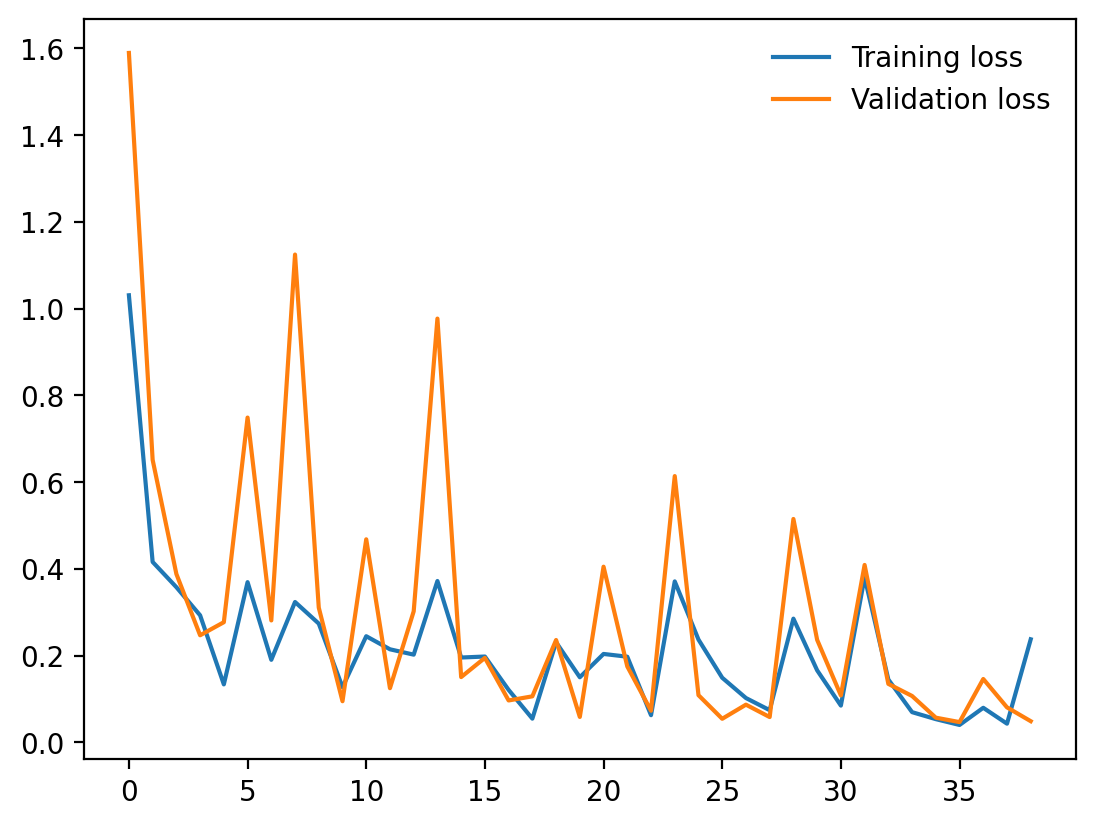

In [18]:
plt.plot(train_losses, label='Training loss')
plt.plot(test_losses, label='Validation loss')
plt.legend(frameon=False)
plt.show()

In [19]:
data_dir = "output"
test_transforms = transforms.Compose([transforms.Resize(224),transforms.ToTensor(),])

In [20]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model=torch.load('chordmodel.pth')
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [21]:
def predict_image(image):
    image_tensor = test_transforms(image).float()
    image_tensor = image_tensor.unsqueeze_(0)
    input = image_tensor.detach().clone() # this just gets a copy of the tensor
    input = input.to(device)
    output = model(input)
    index = output.data.cpu().numpy().argmax()
    return index

In [44]:
classes = ['A', 'B', 'C', 'D', 'E', 'F', 'G','_BG']
def get_random_images(num):
    data = datasets.ImageFolder(data_dir, transform=test_transforms)
    classes = data.classes
    indices = list(range(len(data)))
    np.random.shuffle(indices)
    idx = indices[:num]
    from torch.utils.data.sampler import SubsetRandomSampler
    sampler = SubsetRandomSampler(idx)
    loader = torch.utils.data.DataLoader(data, 
                   sampler=sampler, batch_size=num)
    # dataiter = iter(loader)
    # images, labels = dataiter.next()
    images, labels = next(iter(loader))
    return images, labels

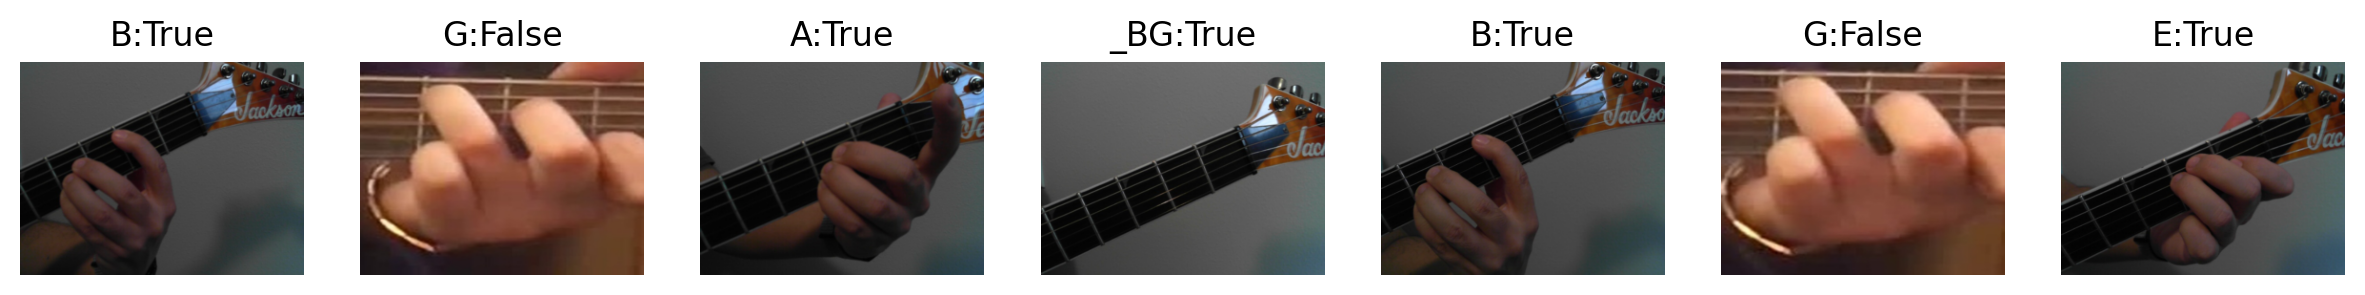

In [54]:
to_pil = transforms.ToPILImage()
images, labels = get_random_images(7)
fig=plt.figure(figsize=(15,15))
for ii in range(len(images)):
    image = to_pil(images[ii])
    index = predict_image(image)
    sub = fig.add_subplot(1, len(images), ii+1)
    res = int(labels[ii]) == index
    #print(classes[index])
    sub.set_title(str(classes[index]) + ":" + str(res))
    plt.axis('off')
    plt.imshow(image)
plt.show()

# Demonstration with live video

In [24]:
vid = cv2.VideoCapture(1)

width  = vid.get(cv2.CAP_PROP_FRAME_WIDTH)
height = vid.get(cv2.CAP_PROP_FRAME_HEIGHT)
textposition = (10,int(height) - 20)

predicted_image = np.zeros((1, 168, 224, 3))
for i in range(10000):
    clear_output(wait=True)
    ret, frame = vid.read()
    
    dim = (224, 168)
    resized = cv2.resize(frame, dim)
    
    predicted_image[0,:,:,:] = resized
    image = to_pil(resized)
    
    y_pred = predict_image(image)
    #print(classes[y_pred]) # sanity check on the prediction
    
    chord_legend = cv2.imread("chords/%s.jpg" % classes[y_pred], cv2.IMREAD_COLOR)    
    frame[0:legend_size, W - legend_size - center_column:W - legend_size - center_column + legend_size] = chord_legend
    
    cv2.putText(frame, "Predicted chord: %s "% classes[y_pred] , textposition, cv2.FONT_HERSHEY_COMPLEX, 1, (0, 0, 255), 2)
    cv2.imshow('Chord prediction', frame)

    keypress = cv2.waitKey(1) & 0xFF
    # if the user pressed "q", then stop looping
    if keypress == ord("q"):
        break

vid.release()
cv2.destroyAllWindows()

error: OpenCV(4.9.0) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\resize.cpp:4152: error: (-215:Assertion failed) !ssize.empty() in function 'cv::resize'
